In [1]:
# cài đặt thư viện cần thiết
!pip install sklearn fuzzy-c-means

You should consider upgrading via the 'C:\Users\nvatu\anaconda3\python.exe -m pip install --upgrade pip' command.


In [2]:
# load thư viện cần thiết

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from fcmeans import FCM
import pickle

In [3]:
# random state
rs = 12

In [4]:
# đọc dữ liệu
df = pd.read_csv('../data/rfm_train.csv')
df

,User number,Recency,Frequency,Moneytary
0,101000281,0.166667,0.001202,0.083520
1,101000282,0.611111,0.000300,0.007971
2,101000283,0.166667,0.000901,0.007971
3,101000320,0.277778,0.000601,0.015943
4,101000325,0.166667,0.000000,0.080000
...,...,...,...,...
8943,106000005,0.055556,0.000000,0.007971
8944,106000011,0.000000,0.000000,0.007971
8945,106000012,0.000000,0.000000,0.007971
8946,106000013,0.000000,0.000000,0.007971


In [5]:
# load trọng số lên
rfm_weight = pd.read_csv('../data/rfm_weight.csv')
rfm_weight

,variable,weight
0,Recency,0.137
1,Frequency,0.328
2,Moneytary,0.535


In [6]:
# lấy trọng số ra
w = rfm_weight.set_index('variable').to_dict()['weight']
w

{'Recency': 0.137, 'Frequency': 0.328, 'Moneytary': 0.535}

In [7]:
# nhân trọng số vào mỗi cột
df.iloc[:, 1:] = df.iloc[:, 1:].apply(lambda x: x * w[x.name])

In [8]:
df

,User number,Recency,Frequency,Moneytary
0,101000281,0.022833,0.000394,0.044683
1,101000282,0.083722,0.000099,0.004265
2,101000283,0.022833,0.000296,0.004265
3,101000320,0.038056,0.000197,0.008529
4,101000325,0.022833,0.000000,0.042800
...,...,...,...,...
8943,106000005,0.007611,0.000000,0.004265
8944,106000011,0.000000,0.000000,0.004265
8945,106000012,0.000000,0.000000,0.004265
8946,106000013,0.000000,0.000000,0.004265


## Chuẩn bị dữ liệu

In [9]:
cust_id = df.iloc[:, 0].values
X = df.iloc[:, 1:].values
cust_id, X

(array([101000281, 101000282, 101000283, ..., 106000012, 106000013,
        106000017], dtype=int64),
 array([[2.28333333e-02, 3.94230769e-04, 4.46832000e-02],
        [8.37222222e-02, 9.85576923e-05, 4.26471429e-03],
        [2.28333333e-02, 2.95673077e-04, 4.26471429e-03],
        ...,
        [0.00000000e+00, 0.00000000e+00, 4.26471429e-03],
        [0.00000000e+00, 0.00000000e+00, 4.26471429e-03],
        [0.00000000e+00, 0.00000000e+00, 4.28000000e-02]]))

# Phân cụm

## KMeans

In [10]:
# dùng thang đo silhouette để chọn số cụm
# để số cụm từ 3 -> 10

range_k = np.arange(2, 11)
range_k

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10])

In [11]:
def make_kmean(k: int):
    model = KMeans(n_clusters=k, random_state=rs)
    model.fit(X)
    cluster_labels = model.predict(X)
    sil_score = silhouette_score(X, cluster_labels)
    print(f"K: {k} done")
    return dict(
        k=k,
        cluster_labels=cluster_labels,
        sil_score=sil_score
    )

In [12]:
kmean_final_cluster = [make_kmean(k) for k in range_k]

K: 2 done
K: 3 done
K: 4 done
K: 5 done
K: 6 done
K: 7 done
K: 8 done
K: 9 done
K: 10 done


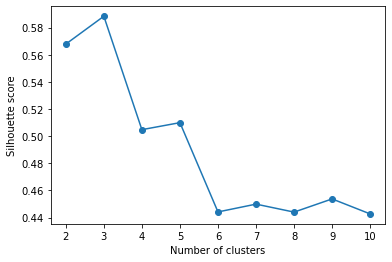

In [13]:
sil_scores = np.array([i['sil_score'] for i in kmean_final_cluster])

plt.plot(range_k, sil_scores)
plt.scatter(range_k, sil_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.savefig('Kmean sil plot.png')
plt.show()

In [14]:
# sắp xếp các mô hình KMean theo chỉ số sihouette (từ cao xuống thấp)
sorted_kmean_final_cluster = sorted(kmean_final_cluster, key=lambda x: x['sil_score'], reverse=True)

In [15]:
sorted_kmean_final_cluster

[{'k': 3,
  'cluster_labels': array([1, 0, 1, ..., 1, 1, 1]),
  'sil_score': 0.5883969142019085},
 {'k': 2,
  'cluster_labels': array([1, 0, 1, ..., 1, 1, 1]),
  'sil_score': 0.567854403858411},
 {'k': 5,
  'cluster_labels': array([0, 2, 0, ..., 0, 0, 0]),
  'sil_score': 0.5099489145235699},
 {'k': 4,
  'cluster_labels': array([2, 0, 2, ..., 2, 2, 2]),
  'sil_score': 0.5047862000945788},
 {'k': 9,
  'cluster_labels': array([0, 4, 3, ..., 3, 3, 0]),
  'sil_score': 0.45372539490857206},
 {'k': 7,
  'cluster_labels': array([1, 0, 1, ..., 1, 1, 1]),
  'sil_score': 0.4498875440043108},
 {'k': 6,
  'cluster_labels': array([1, 0, 1, ..., 1, 1, 1]),
  'sil_score': 0.44412850265070747},
 {'k': 8,
  'cluster_labels': array([1, 6, 1, ..., 1, 1, 1]),
  'sil_score': 0.4440082709909465},
 {'k': 10,
  'cluster_labels': array([9, 8, 0, ..., 6, 6, 9]),
  'sil_score': 0.44267068452043484}]

In [16]:
# lấy mô hình có giá trị sihouette tốt nhất

best_k_kmean = sorted_kmean_final_cluster[0]['k']
kmean_cluster_labels = sorted_kmean_final_cluster[0]['cluster_labels']
kmean_sil_score = sorted_kmean_final_cluster[0]['sil_score']
print(f'Số cụm tốt nhất cho KMeans là {best_k_kmean} với giá trị sihouette: {kmean_sil_score}')

Số cụm tốt nhất cho KMeans là 3 với giá trị sihouette: 0.5883969142019085


In [17]:
# chạy lại model
print(f"Chạy lại model với K = {best_k_kmean} cho K Means")
kmean_model = KMeans(n_clusters=best_k_kmean, random_state=rs)
kmean_model.fit(X)

Chạy lại model với K = 3 cho K Means


KMeans(n_clusters=3, random_state=12)

In [18]:
# Lưu lại mô hình
with open('../data/kmean_model.pkl', 'wb') as f:
    pickle.dump(kmean_model, f, pickle.HIGHEST_PROTOCOL)

In [19]:
kmean_cluster_df = pd.DataFrame(
    {'User number': cust_id, 'Cluster Label': kmean_cluster_labels}
)
df_merged_kmean = df.merge(kmean_cluster_df, on='User number')
df_merged_kmean.to_csv('../data/cluster_kmeans.csv', index=False)

In [20]:
print("Trung bình giá trị trên mỗi cụm của KMeans")
df_merged_kmean.groupby('Cluster Label').mean().iloc[:, 1:]

Trung bình giá trị trên mỗi cụm của KMeans


,Recency,Frequency,Moneytary
Cluster Label,,,
0,0.101141,0.000053,0.014265
1,0.027513,0.000585,0.011223
2,0.062508,0.000106,0.181037


In [21]:
print("Số lượng khách hàng mỗi cụm")
kmean_cluster_df.groupby('Cluster Label').count()

Số lượng khách hàng mỗi cụm


,User number
Cluster Label,
0,3669
1,5138
2,141


### Fuzzy C-Mean

In [22]:
def make_fuzzycmean(k: int):
    model = FCM(n_clusters=k, random_state=rs)
    model.fit(X)
    cluster_labels = model.predict(X)
    sil_score = silhouette_score(X, cluster_labels)
    print(f"K: {k} done")
    return dict(
        k=k,
        cluster_labels=cluster_labels,
        sil_score=sil_score
    )

In [23]:
fuzzycmean_final_cluster = [make_fuzzycmean(k) for k in range_k]

K: 2 done
K: 3 done
K: 4 done
K: 5 done
K: 6 done
K: 7 done
K: 8 done
K: 9 done
K: 10 done


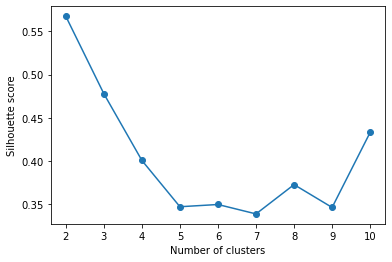

In [24]:
sil_scores = np.array([i['sil_score'] for i in fuzzycmean_final_cluster])

plt.plot(range_k, sil_scores)
plt.scatter(range_k, sil_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.savefig('Fuzzy C-Mean sil plot.png')
plt.show()

In [25]:
# sắp xếp các mô hình Fuzzy C Mean theo chỉ số sihouette (từ cao xuống thấp)
sorted_fuzzycmean_final_cluster = sorted(fuzzycmean_final_cluster, key=lambda x: x['sil_score'], reverse=True)

In [26]:
sorted_fuzzycmean_final_cluster

[{'k': 2,
  'cluster_labels': array([0, 1, 0, ..., 0, 0, 0], dtype=int64),
  'sil_score': 0.5675617110094935},
 {'k': 3,
  'cluster_labels': array([1, 0, 1, ..., 1, 1, 1], dtype=int64),
  'sil_score': 0.477789268160729},
 {'k': 10,
  'cluster_labels': array([5, 3, 0, ..., 7, 7, 5], dtype=int64),
  'sil_score': 0.43292438057425514},
 {'k': 4,
  'cluster_labels': array([1, 0, 1, ..., 1, 1, 1], dtype=int64),
  'sil_score': 0.40043131751134936},
 {'k': 8,
  'cluster_labels': array([3, 7, 3, ..., 1, 1, 1], dtype=int64),
  'sil_score': 0.3724046299402179},
 {'k': 6,
  'cluster_labels': array([0, 1, 0, ..., 2, 2, 2], dtype=int64),
  'sil_score': 0.34934531410791775},
 {'k': 5,
  'cluster_labels': array([0, 1, 0, ..., 4, 4, 4], dtype=int64),
  'sil_score': 0.34674760163089685},
 {'k': 9,
  'cluster_labels': array([5, 8, 5, ..., 4, 4, 4], dtype=int64),
  'sil_score': 0.34592946638038496},
 {'k': 7,
  'cluster_labels': array([6, 4, 6, ..., 2, 2, 2], dtype=int64),
  'sil_score': 0.338428709272373

In [27]:
# lấy mô hình có giá trị sihouette tốt nhất

best_k_fuzzycmean = sorted_fuzzycmean_final_cluster[0]['k']
fuzzycmean_cluster_labels = sorted_fuzzycmean_final_cluster[0]['cluster_labels']
fuzzycmean_sil_score = sorted_fuzzycmean_final_cluster[0]['sil_score']
print(f'Số cụm tốt nhất cho KMeans là {best_k_fuzzycmean} với giá trị sihouette: {fuzzycmean_sil_score}')

Số cụm tốt nhất cho KMeans là 2 với giá trị sihouette: 0.5675617110094935


In [28]:
# chạy lại model
print(f"Chạy lại model với K = {best_k_fuzzycmean} cho Fuzzy C-Mean")
fcm_model = FCM(n_clusters=best_k_fuzzycmean, random_state=rs)
fcm_model.fit(X)

Chạy lại model với K = 2 cho Fuzzy C-Mean


In [29]:
# Lưu lại mô hình
with open('../data/fuzzycmean_model.pkl', 'wb') as f:
    pickle.dump(fcm_model, f, pickle.HIGHEST_PROTOCOL)

In [30]:
fuzzycmean_cluster_df = pd.DataFrame(
    {'User number': cust_id, 'Cluster Label': fuzzycmean_cluster_labels}
)
df_merged_fuzzy = df.merge(fuzzycmean_cluster_df, on='User number')
df_merged_fuzzy.to_csv('../data/cluster_fuzzycmean.csv', index=False)

In [31]:
print("Trung bình giá trị trên mỗi cụm của Fuzzy C-Mean")
df_merged_fuzzy.groupby('Cluster Label').mean().iloc[:, 1:]

Trung bình giá trị trên mỗi cụm của Fuzzy C-Mean


,Recency,Frequency,Moneytary
Cluster Label,,,
0,0.027452,0.000579,0.013226
1,0.101029,0.000054,0.017812


In [32]:
print("Số lượng khách hàng mỗi cụm")
fuzzycmean_cluster_df.groupby('Cluster Label').count()

Số lượng khách hàng mỗi cụm


,User number
Cluster Label,
0,5202
1,3746
